In [1]:
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from core import bw_color_palette
import gpplot

In [31]:
def interpolate_precision(common_recall, obs_precision, obs_recall):
    interpolated_precision = list()
    pr_df = pd.DataFrame({'precision': obs_precision, 
                          'recall': obs_recall})
    for cutoff in common_recall:
        filtered_pr_df = pr_df[pr_df['recall'] >= cutoff]
        curr_recall = filtered_pr_df['recall'].min()
        curr_precision = filtered_pr_df.loc[filtered_pr_df['recall'] == curr_recall, 
                                            'precision'].mean()
        interpolated_precision.append(curr_precision)
    return interpolated_precision
    

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


In [4]:
def top_k_score(df, y_true, y_pred, k):
    score = (df.sort_values(y_pred, ascending=False)
             .head(k)
             [y_true]
             .mean())
    return score

In [13]:
def evaluate_predictions(cat_predictions, model_seq_info, top_per_functional_group=False):
    metric_list = list()
    for method, method_df in cat_predictions.groupby('method'):
        print(method)
        merged_method_df = model_seq_info.merge(method_df)
        for test_fold, test_fold_df in merged_method_df.groupby('test_fold'):
            if top_per_functional_group:
                test_fold_df = (test_fold_df.sort_values('prediction', ascending=False)
                                .groupby('functional_group')
                                .head(1))
            test_fold_df = (test_fold_df.sample(frac=1, random_state=7)
                            .reset_index(drop=True)) # shuffle
            ap = metrics.average_precision_score(test_fold_df['defensive'], test_fold_df['prediction'])
            auroc = metrics.roc_auc_score(test_fold_df['defensive'], test_fold_df['prediction'])
            top_10_precision = top_k_score(test_fold_df, 'defensive', 'prediction', 10)
            top_60_precision = top_k_score(test_fold_df, 'defensive', 'prediction', 60)
            metric_list.append(
                {'method': method, 
                 'fold': test_fold,
                 'ap': ap, 
                 'auroc': auroc, 
                 'top_10_precision': top_10_precision, 
                 'top_60_precision': top_60_precision})
    metric_df = pd.DataFrame(metric_list)
    metric_cols = ['ap', 'auroc', 'top_10_precision', 'top_60_precision']
    agg_metric_df = (metric_df.groupby('method')
                     .agg({m: ['mean', 'std'] for m in metric_cols})
                     .sort_values(('ap', 'mean'), ascending=False))
    return metric_df, agg_metric_df

In [6]:
pred_f_list = ['../data3/interim/cv_predictions_hmm.pq', 
               '../data3/interim/cv_predictions_mmseqs_profile.pq', 
               '../data3/interim/cv_predictions_blast.pq', 
               '../data3/interim/cv_predictions_defense_blast.pq', 
               '../data3/interim/cv_predictions_esm2_650M.pq', 
               '../data3/interim/cv_predictions_esm2_150M.pq', 
               '../data3/interim/cv_predictions_gba.pq', 
               '../data3/interim/cv_predictions_defense_predictor.pq', 
               '../data3/interim/cv_predictions_foldseek.pq', 
               '../data3/interim/cv_predictions_deepgo_se.pq', 
               '../data3/interim/cv_predictions_control_blast.pq']

In [7]:
model_seq_info = pd.read_parquet('../data3/interim/model_seq_info.pq')
pred_list = [pd.read_parquet(f) for f in tqdm(pred_f_list, position=0)]

100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


In [8]:
random_predictions = model_seq_info[['seq_id']].copy()
random_predictions['prediction'] = 0 
random_predictions['method'] = 'Random'

In [9]:
pred_list.append(random_predictions)

In [10]:
cat_predictions = pd.concat(pred_list)

In [11]:
model_seq_info['functional_group'].nunique()

1659

In [14]:
all_fold_metric_df, all_agg_metric_df = evaluate_predictions(cat_predictions, model_seq_info, top_per_functional_group=False)

BLAST nearest neighbor
Control BLAST search
DeepGO-SE
Defense BLAST search
Defense HMM search
DefensePredictor
ESM2 150M nearest neighbor
ESM2 650M nearest neighbor
Foldseek/ProstT5 nearest neighbor
Guilt-by-association (frequency)
Guilt-by-association (p-value)
MMseqs profile nearest neighbor
Random


In [15]:
all_agg_metric_df

ap               auroc             
                                       mean       std      mean       std   
method                                                                      
DefensePredictor                   0.873443  0.089250  0.983711  0.007930  \
ESM2 650M nearest neighbor         0.510068  0.160894  0.816029  0.059190   
ESM2 150M nearest neighbor         0.505428  0.181971  0.775877  0.048938   
Guilt-by-association (p-value)     0.309090  0.092767  0.702214  0.024072   
DeepGO-SE                          0.278076  0.167344  0.809945  0.042826   
Foldseek/ProstT5 nearest neighbor  0.258482  0.157769  0.755322  0.088860   
Guilt-by-association (frequency)   0.200212  0.095845  0.693362  0.023346   
BLAST nearest neighbor             0.168697  0.129843  0.739141  0.050186   
MMseqs profile nearest neighbor    0.165868  0.107462  0.774960  0.043010   
Control BLAST search               0.119891  0.070739  0.709380  0.068284   
Defense HMM search                 0.100947  0.093753  0.541389  0.056617   
Defense BLAST search               0.099030  0.084122  0.584623  0.053698   
Random                             0.072113  0.049872  0.500000  0.000000   

                                  top_10_precision           top_60_precision   
                                              mean       std             mean   
method                                                                          
DefensePredictor                              1.00  0.000000         0.993333  \
ESM2 650M nearest neighbor                    0.62  0.238747         0.633333   
ESM2 150M nearest neighbor                    0.72  0.258844         0.726667   
Guilt-by-association (p-value)                0.84  0.250998         0.816667   
DeepGO-SE                                     0.58  0.443847         0.553333   
Foldseek/ProstT5 nearest neighbor             0.26  0.320936         0.236667   
Guilt-by-association (frequency)              0.24  0.230217         0.270000   
BLAST nearest neighbor                        0.08  0.130384         0.203333   
MMseqs profile nearest neighbor               0.16  0.181659         0.250000   
Control BLAST search                          0.14  0.134164         0.113333   
Defense HMM search                            0.08  0.130384         0.143333   
Defense BLAST search                          0.08  0.130384         0.080000   
Random                                        0.12  0.083666         0.060000   

                                             
                                        std  
method                                       
DefensePredictor                   0.009129  
ESM2 650M nearest neighbor         0.166249  
ESM2 150M nearest neighbor         0.249611  
Guilt-by-association (p-value)     0.140929  
DeepGO-SE                          0.304458  
Foldseek/ProstT5 nearest neighbor  0.247880  
Guilt-by-association (frequency)   0.133542  
BLAST nearest neighbor             0.329436  
MMseqs profile nearest neighbor    0.274115  
Control BLAST search               0.082832  
Defense HMM search                 0.216538  
Defense BLAST search               0.075829  
Random                             0.032489

In [16]:
top_fold_metric_df, top_agg_metric_df = evaluate_predictions(cat_predictions, model_seq_info, top_per_functional_group=True)

BLAST nearest neighbor
Control BLAST search
DeepGO-SE
Defense BLAST search
Defense HMM search
DefensePredictor
ESM2 150M nearest neighbor
ESM2 650M nearest neighbor
Foldseek/ProstT5 nearest neighbor
Guilt-by-association (frequency)
Guilt-by-association (p-value)
MMseqs profile nearest neighbor
Random


In [17]:
top_fold_metric_df

,method,fold,ap,auroc,top_10_precision,top_60_precision
0,BLAST nearest neighbor,0,0.450260,0.845813,0.6,0.550000
1,BLAST nearest neighbor,1,0.222265,0.772210,0.1,0.216667
2,BLAST nearest neighbor,2,0.262653,0.798863,0.1,0.300000
3,BLAST nearest neighbor,3,0.278145,0.765368,0.1,0.400000
4,BLAST nearest neighbor,4,0.258196,0.768415,0.0,0.366667
...,...,...,...,...,...,...
60,Random,0,0.101302,0.500000,0.2,0.150000
61,Random,1,0.104230,0.500000,0.4,0.116667
62,Random,2,0.106317,0.500000,0.1,0.100000
63,Random,3,0.105023,0.500000,0.1,0.100000


In [18]:
top_agg_metric_df

ap               auroc             
                                       mean       std      mean       std   
method                                                                      
DefensePredictor                   0.861215  0.033855  0.971491  0.012893  \
Guilt-by-association (p-value)     0.633112  0.113474  0.917223  0.029854   
ESM2 150M nearest neighbor         0.505665  0.105754  0.861593  0.038875   
DeepGO-SE                          0.485870  0.127677  0.856042  0.058678   
ESM2 650M nearest neighbor         0.456993  0.070550  0.862802  0.033706   
Foldseek/ProstT5 nearest neighbor  0.375310  0.111027  0.818295  0.047113   
BLAST nearest neighbor             0.294304  0.089553  0.790134  0.033848   
Guilt-by-association (frequency)   0.274396  0.064052  0.825233  0.043400   
Defense HMM search                 0.250896  0.109479  0.700958  0.069886   
MMseqs profile nearest neighbor    0.246070  0.086992  0.748688  0.042381   
Defense BLAST search               0.218100  0.076650  0.714712  0.061468   
Control BLAST search               0.146480  0.025783  0.639494  0.051080   
Random                             0.103849  0.002017  0.500000  0.000000   

                                  top_10_precision           top_60_precision   
                                              mean       std             mean   
method                                                                          
DefensePredictor                              1.00  0.000000         0.830000  \
Guilt-by-association (p-value)                0.78  0.268328         0.690000   
ESM2 150M nearest neighbor                    0.62  0.294958         0.520000   
DeepGO-SE                                     0.62  0.228035         0.556667   
ESM2 650M nearest neighbor                    0.60  0.234521         0.433333   
Foldseek/ProstT5 nearest neighbor             0.28  0.192354         0.443333   
BLAST nearest neighbor                        0.18  0.238747         0.366667   
Guilt-by-association (frequency)              0.24  0.181659         0.270000   
Defense HMM search                            0.28  0.248998         0.356667   
MMseqs profile nearest neighbor               0.26  0.151658         0.403333   
Defense BLAST search                          0.10  0.070711         0.253333   
Control BLAST search                          0.16  0.114018         0.146667   
Random                                        0.20  0.122474         0.123333   

                                             
                                        std  
method                                       
DefensePredictor                   0.054518  
Guilt-by-association (p-value)     0.096177  
ESM2 150M nearest neighbor         0.081989  
DeepGO-SE                          0.088663  
ESM2 650M nearest neighbor         0.054006  
Foldseek/ProstT5 nearest neighbor  0.136728  
BLAST nearest neighbor             0.124164  
Guilt-by-association (frequency)   0.113896  
Defense HMM search                 0.109036  
MMseqs profile nearest neighbor    0.113284  
Defense BLAST search               0.107626  
Control BLAST search               0.060553  
Random                             0.025276

In [19]:
formatted_top_cluster_df = pd.DataFrame(index=top_agg_metric_df.index)
for metric in top_agg_metric_df.columns.levels[0]:
    # Apply a lambda function to each row in the metric column grouping, 
    # formatting both the mean and std to two decimal places.
    formatted_top_cluster_df[metric] = top_agg_metric_df[metric].apply(
        lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1
    )
formatted_top_cluster_df

,ap,auroc,top_10_precision,top_60_precision
method,,,,
DefensePredictor,0.861 ± 0.034,0.971 ± 0.013,1.000 ± 0.000,0.830 ± 0.055
Guilt-by-association (p-value),0.633 ± 0.113,0.917 ± 0.030,0.780 ± 0.268,0.690 ± 0.096
ESM2 150M nearest neighbor,0.506 ± 0.106,0.862 ± 0.039,0.620 ± 0.295,0.520 ± 0.082
DeepGO-SE,0.486 ± 0.128,0.856 ± 0.059,0.620 ± 0.228,0.557 ± 0.089
ESM2 650M nearest neighbor,0.457 ± 0.071,0.863 ± 0.034,0.600 ± 0.235,0.433 ± 0.054
Foldseek/ProstT5 nearest neighbor,0.375 ± 0.111,0.818 ± 0.047,0.280 ± 0.192,0.443 ± 0.137
BLAST nearest neighbor,0.294 ± 0.090,0.790 ± 0.034,0.180 ± 0.239,0.367 ± 0.124
Guilt-by-association (frequency),0.274 ± 0.064,0.825 ± 0.043,0.240 ± 0.182,0.270 ± 0.114
Defense HMM search,0.251 ± 0.109,0.701 ± 0.070,0.280 ± 0.249,0.357 ± 0.109


In [20]:
formatted_top_cluster_df

,ap,auroc,top_10_precision,top_60_precision
method,,,,
DefensePredictor,0.861 ± 0.034,0.971 ± 0.013,1.000 ± 0.000,0.830 ± 0.055
Guilt-by-association (p-value),0.633 ± 0.113,0.917 ± 0.030,0.780 ± 0.268,0.690 ± 0.096
ESM2 150M nearest neighbor,0.506 ± 0.106,0.862 ± 0.039,0.620 ± 0.295,0.520 ± 0.082
DeepGO-SE,0.486 ± 0.128,0.856 ± 0.059,0.620 ± 0.228,0.557 ± 0.089
ESM2 650M nearest neighbor,0.457 ± 0.071,0.863 ± 0.034,0.600 ± 0.235,0.433 ± 0.054
Foldseek/ProstT5 nearest neighbor,0.375 ± 0.111,0.818 ± 0.047,0.280 ± 0.192,0.443 ± 0.137
BLAST nearest neighbor,0.294 ± 0.090,0.790 ± 0.034,0.180 ± 0.239,0.367 ± 0.124
Guilt-by-association (frequency),0.274 ± 0.064,0.825 ± 0.043,0.240 ± 0.182,0.270 ± 0.114
Defense HMM search,0.251 ± 0.109,0.701 ± 0.070,0.280 ± 0.249,0.357 ± 0.109


In [32]:
pr_list = list()
og_pr_list = list()
top_pred_list = list()
common_recall = np.linspace(0, 1, 70)
top_per_functional_group = True
for method, method_df in cat_predictions.groupby('method'):
    print(method)
    merged_method_df = model_seq_info.merge(method_df)
    for test_fold, test_fold_df in merged_method_df.groupby('test_fold'):
        if top_per_functional_group:
            test_fold_df = (test_fold_df.sort_values('prediction', ascending=False)
                            .groupby('functional_group')
                            .head(1))
        test_fold_df = test_fold_df.sample(frac=1, random_state=7) # shuffle
        top_pred_list.append(test_fold_df)
        precision, recall, cutoff = metrics.precision_recall_curve(test_fold_df['defensive'], test_fold_df['prediction'])
        pr_df = (pd.DataFrame({'precision': precision, 
                              'recall': recall,
                               'prediction': np.append(cutoff, np.nan)})
                 .merge(test_fold_df, how='left', on='prediction')
                 .sort_values('prediction', ascending=False))
        pr_df['method'] = pr_df['method'].fillna(method)
        pr_df['test_fold'] = test_fold
        og_pr_list.append(pr_df)
        interp_precision = interpolate_precision(common_recall, precision, recall)
        interp_pr_df = pd.DataFrame({'recall': common_recall, 
                                     'precision': interp_precision})
        interp_pr_df['method'] = method
        interp_pr_df['test_fold'] = test_fold
        pr_list.append(interp_pr_df)

BLAST nearest neighbor


Control BLAST search
DeepGO-SE
Defense BLAST search
Defense HMM search
DefensePredictor
ESM2 150M nearest neighbor
ESM2 650M nearest neighbor
Foldseek/ProstT5 nearest neighbor
Guilt-by-association (frequency)
Guilt-by-association (p-value)
MMseqs profile nearest neighbor
Random


In [33]:
pr_df = pd.concat(pr_list)

In [34]:
name_df = formatted_top_cluster_df.reset_index()
name_df['Method'] = name_df['method'] + ' (AP = ' + name_df['ap'] + ')'
name_df['Method'] = pd.Categorical(name_df['Method'], categories=name_df['Method'])

In [35]:
merged_pr_df = (pr_df.merge(name_df, how='inner', 
                            on='method'))

In [36]:
highlight = ['DefensePredictor', 
             'Guilt-by-association (p-value)', 
             'ESM2 150M nearest neighbor', 'Foldseek/ProstT5 nearest neighbor',
             'BLAST nearest neighbor', 'Defense HMM search', 'Random']

In [37]:
highlight_df = merged_pr_df[merged_pr_df['method'].isin(highlight)].reset_index(drop=True)
highlight_df['Method'] = highlight_df['Method'].cat.remove_unused_categories()

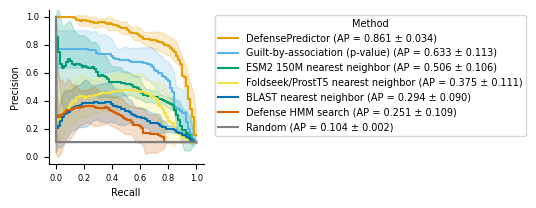

In [38]:
fig, ax = plt.subplots(figsize=(2,2))
sns.lineplot(data=highlight_df, 
              x='recall', y='precision', errorbar='sd', estimator='mean',
              hue='Method', palette=bw_color_palette[:(len(highlight) - 1)] + ['grey'], 
             drawstyle='steps-pre')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05,1.05)
sns.despine()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title='Method')
plt.savefig('../figures/pr_curve.svg', bbox_inches='tight', dpi=300)

In [27]:
og_pr_df = pd.concat(og_pr_list)

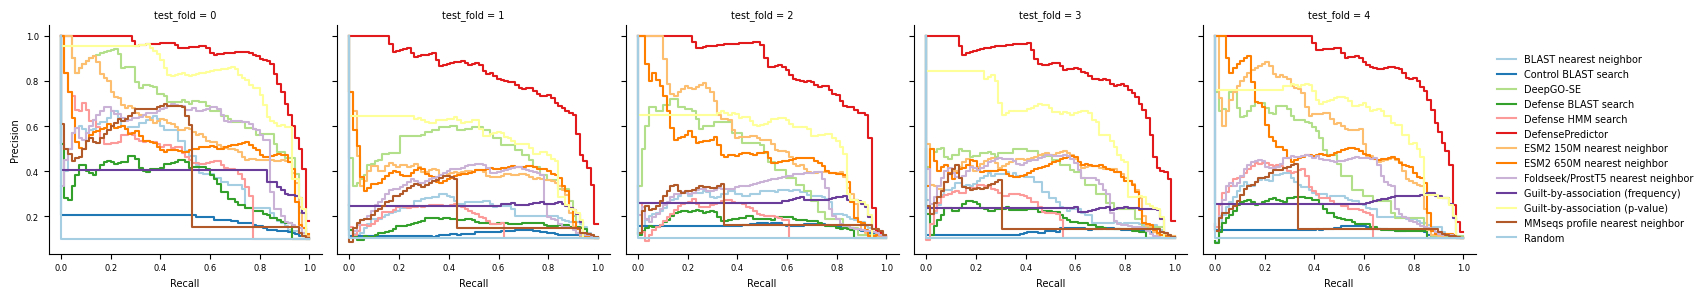

In [28]:
g = sns.FacetGrid(data=og_pr_df, col='test_fold')
g.map_dataframe(sns.lineplot, x='recall', y='precision', hue='method', palette='Paired', 
                errorbar=None, drawstyle='steps-pre')
g.set_axis_labels('Recall', 'Precision')
g.add_legend()

In [31]:
formatted_top_cluster_df.to_parquet('../data3/interim/formatted_eval_results.pq', index=True)

## Compare GBA and DP

In [26]:
top_pred_df = pd.concat(top_pred_list)

In [33]:
(top_pred_df.loc[top_pred_df['method'] == 'BLAST nearest neighbor', 'prediction'] == 0).mean()

0.11371137113711371

In [32]:
top_pred_df[top_pred_df['method'] == 'BLAST nearest neighbor'].sort_values('prediction', ascending=True).head(50)

,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,prediction,method
195837,WP_067873181.1,f9be185829aa9e1bb7d3365f627e8337dc326f09a8392e...,MPLYLPSWIPPQVVEIVAGHIPVGNEDKMRRCGDHYSACANELRKK...,adenosine deaminase,purine-containing compound salvage,None,None,False,GCF_001613265,None,None,purine-containing compound salvage,b10,1,WP_067873181.1|NZ_BDCA01000011.1|27444|+,NZ_BDCA01000011.1,27444,+,-2281.0,BLAST nearest neighbor
116395,WP_245737917.1,8c8df95cc8f4fe2a0c50de840ef973d257961bb969aba9...,MAQTECGLCCCVAVLRYHGRAEEISTARQVMEAGRDGLSATQLARF...,type 2 lanthipeptide synthetase LanM,peptide cross-linking via lanthionine or 3-met...,None,None,False,GCF_001704635,None,None,peptide cross-linking via lanthionine or 3-met...,b19,1,WP_245737917.1|NZ_MAXF01000030.1|20399|+,NZ_MAXF01000030.1,20399,+,-990.0,BLAST nearest neighbor
50224,WP_013548516.1,30c72637c89cba79d7e42a6f22b0cca22014eacd8fada4...,MKKYPKIGIRPTIDGRQGGVRESLEEKTMGLAKAVADLISSNLKNG...,L-fucose isomerase,L-fucose biosynthetic process,None,None,False,GCF_000186225,None,None,L-fucose biosynthetic process,b5341,1,WP_013548516.1|NC_014933.1|3554647|-,NC_014933.1,3554647,-,-482.0,BLAST nearest neighbor
135395,WP_014454706.1,a6bbf22ee6cc74dcee6079b928fa370d44989adf6183dc...,MEVSMSVIDTLWVVTAAALVFFMQAGFSLLESGLTRSKNSINVAIK...,ammonium transporter,ammonium transmembrane transport,None,None,False,GCF_000242595,None,None,ammonium transmembrane transport,b95,4,WP_014454706.1|NC_017098.1|702987|+,NC_017098.1,702987,+,-474.0,BLAST nearest neighbor
42057,WP_162660071.1,258e5c52436d76433c598a429a53290ba57b813e8ebba3...,MPRNIRHKGVDVMADWLEQVDRWWRRTMGEASPDSVGRGVLAVSGG...,bifunctional phosphoribosylaminoimidazolecarbo...,purine nucleotide biosynthetic process,None,None,False,GCF_901538355,None,None,purine nucleotide biosynthetic process,b37,1,WP_162660071.1|NZ_LR593887.1|5780654|+,NZ_LR593887.1,5780654,+,-469.0,BLAST nearest neighbor
172946,WP_152053111.1,da626aab63be281c1a6b1166e5ef6187f9353eb7b3a9fe...,MIPHVPCPRCGAILSSDALGPLCPSCVVRQVLLDDTLSDRVGSDGD...,trehalase family glycosidase,trehalose metabolic process,None,None,False,GCF_009177065,None,None,trehalose metabolic process,b5,2,WP_152053111.1|NZ_WEZF01000018.1|43618|-,NZ_WEZF01000018.1,43618,-,-445.0,BLAST nearest neighbor
187069,WP_009601436.1,edc60675a4d3aa50b378c9b29275e138028748c2adf09e...,MHINYHIYQLILIVACLSFSPTALANTDIQPTLDIIWVATATGLVF...,ammonium transporter,ammonium transmembrane transport,None,None,False,GCF_000165125,None,None,ammonium transmembrane transport,b53,1,WP_009601436.1|NZ_AEIU01000074.1|75267|-,NZ_AEIU01000074.1,75267,-,-426.0,BLAST nearest neighbor
167964,WP_004188274.1,d3b66acd25cdada508462b8b238e87cfeee229b9ce7963...,MHRFETIRQLESSARTYASSFEAVFESGAGALLRDQSGREIIDCLS...,diaminobutyrate--2-oxoglutarate transaminase f...,ectoine biosynthetic process,None,None,False,GCF_002346025,None,None,ectoine biosynthetic process,b8,4,WP_004188274.1|NZ_CP009728.1|1547779|-,NZ_CP009728.1,1547779,-,-424.0,BLAST nearest neighbor
67225,WP_200392267.1,48a98ac36df52a1964d4f847ce32d8020a9fc98fc7e669...,MISLVLTGGVASGKSSLAKLLSDRVENLLLFDCDAEVGQLLTEEAV...,transcription termination factor Rho,DNA-templated transcription termination,None,None,False,GCF_016595415,None,None,DNA-templated transcription termination,b31,2,WP_200392267.1|NZ_JAENIO010000033.1|21862|+,NZ_JAENIO010000033.1,21862,+,-412.0,BLAST nearest neighbor
140536,WP_095511782.1,adfb5437ddef844c65478938029fcedaf1afb906529c01...,MKKEIVINASKDRSRIAIVENGELVELYVENPDNVRTIGNVYLGRV...,Rne/Rng family ribonuclease,RNA catabolic process,None,None,False,GCF_002283365,None,None,RNA catabolic process,b13252,0,WP_095511782.1|NZ_MQWD01000001.1|4081679|-,NZ_MQWD01000001.1,4081679,-,-412.0,BLAST nearest neighbor


In [31]:
top_pred_df[top_pred_df['method'] == 'BLAST nearest neighbor'].sort_values('prediction', ascending=False).head(50)

,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,prediction,method
119247,WP_137986286.1,90680a4d88816d41f0736c3eb6fd828d14811ac5e965cc...,MPAEYIPFGEPENESERMAINYLRGHLPNSYKIFANLEIKQGVEIF...,protein kinase,protein phosphorylation,None,None,False,GCF_000760695,None,None,protein phosphorylation,b5,2,WP_137986286.1|NZ_JHEG04000001.1|3583234|-,NZ_JHEG04000001.1,3583234,-,935.0,BLAST nearest neighbor
140990,WP_190261695.1,aea8db0cd09aba619c5f5d0c6c03f0e6c6904c5231c1cf...,MTTKVQAIQFLRQALADPKAEFRRGQWEAIEALVDRRERLLIVERT...,RecQ family ATP-dependent DNA helicase,DNA recombination,None,None,False,GCF_014672695,None,None,DNA recombination,b48,1,WP_190261695.1|NZ_CP053923.1|274450|+,NZ_CP053923.1,274450,+,926.0,BLAST nearest neighbor
115916,WP_168058192.1,8be89a7980cadaae21525e944b3432e536a27e65c261b9...,MPIIPKDQIQFDETDASASPPGGQIYKPDQIRFDDEPAQGKGLSVA...,diguanylate cyclase,regulation of signal transduction,None,None,False,GCF_012184425,None,None,regulation of signal transduction,b11070,4,WP_168058192.1|NZ_VTOW01000001.1|812797|+,NZ_VTOW01000001.1,812797,+,805.0,BLAST nearest neighbor
15617,WP_246400048.1,01629c2fd8fc53eed29a2e4f6131e0d918ed6165742ebb...,MVNRRERRLVVQRTGWGKSYVYFISTRILRDRGRGPTLIVSPLLAL...,DNA-processing protein DprA,DNA mediated transformation,None,None,False,GCF_014201905,None,None,DNA mediated transformation,b48,1,WP_246400048.1|NZ_JACHFM010000012.1|3783|-,NZ_JACHFM010000012.1,3783,-,775.0,BLAST nearest neighbor
2090,WP_004072952.1,912f59e8c4916ec3b4a45f4109c41ee2f549f7cf398e54...,MEIKNLFDTNKDIYRTIEKVITYGASQQARLKAEISEYVVTESIEE...,None,None,None,None,True,GCF_000233695,RM_Type_IIG__Type_IIG,RM_Type_IIG__Type_IIG,RM_Type_IIG__Type_IIG,d1,0,WP_004072952.1|NZ_CM001488.1|1948243|-,NZ_CM001488.1,1948243,-,653.0,BLAST nearest neighbor
9648,WP_027137224.1,b95f279148a3bd2ba238a37b173b9cabffc6cb83388a0b...,MSKIKSLFGKDKDIYRGIEKVVTFGNASNENLKHEVSEYVVTERIR...,None,None,None,None,True,GCF_000425645,BREX__brxC,BREX__brxC,BREX__brxC,d177,3,WP_027137224.1|NZ_AUDV01000006.1|476638|-,NZ_AUDV01000006.1,476638,-,642.0,BLAST nearest neighbor
125560,WP_245591604.1,98fc817a6d2a1b071e0b656a5056e634a956b477773676...,MSRPSLDNVPAPERPDPHRAVRVDSPLFGELLLKLGIVTPKQIEEA...,response regulator,phosphorelay signal transduction system,None,None,False,GCF_000335475,None,None,phosphorelay signal transduction system,b4,0,WP_245591604.1|NZ_ANAH02000004.1|55443|-,NZ_ANAH02000004.1,55443,-,605.0,BLAST nearest neighbor
29570,WP_056953144.1,148f4a11cbd767b4899a1cb0a4d1812c6ae47d5489a9c0...,MKNPIMCCALATLGVSQGKIDKLDPTTCHFYDLINEQHVALLWEQL...,sigma factor-like helix-turn-helix DNA-binding...,DNA-templated transcription initiation,None,None,False,GCF_003641185,None,None,DNA-templated transcription initiation,b3537,4,WP_056953144.1|NZ_CP032757.1|1380105|+,NZ_CP032757.1,1380105,+,526.0,BLAST nearest neighbor
35580,WP_164036592.1,1cbfc838048e7aa6dc45891645ba5f2219cbd36f29a4dd...,MQLKEEALFTLKFDGKPVINELGELEKRLIDLKEAQKNVERGTKEW...,phage tail tape measure protein,viral process,None,None,False,GCF_010747415,None,None,viral process,b92,1,WP_164036592.1|NZ_JAAGNZ010000001.1|2245117|-,NZ_JAAGNZ010000001.1,2245117,-,520.0,BLAST nearest neighbor
72491,WP_006979179.1,4fe53d4b7665cea40428cde3e18e3b5a68f39e1474d08b...,MPRKAKPAAPVPSEAPIQAPVEQPILNSPYYEPKEHWVYDKAGKAN...,TIR domain-containing protein,signal transduction,None,None,False,GCF_004341915,None,None,signal transduction,b14,3,WP_006979179.1|NZ_SLWZ01000012.1|9682|-,NZ_SLWZ01000012.1,9682,-,518.0,BLAST nearest neighbor


In [27]:
top_pred_df['method_rank'] = (top_pred_df
                       .groupby('method')
                       ['prediction']
                       .rank(ascending=False))

In [29]:
wide_top_pred_df = (top_pred_df.pivot(index=['functional_group', 'test_fold', 'defensive'], 
                                      columns='method',
                                      values='method_rank')
                    .reset_index())

In [53]:
(wide_top_pred_df.groupby('test_fold')
 .agg({'defensive': ['sum', 'mean']}))

method    defensive          
                sum      mean
test_fold                    
0                70  0.101302
1                69  0.104230
2                69  0.106317
3                69  0.105023
4                69  0.102374

In [30]:
plot_top_pred_df = (wide_top_pred_df.query('defensive')
                    .copy())
plot_top_pred_df['delta'] = (wide_top_pred_df['Guilt-by-association (p-value)'] - 
                             wide_top_pred_df['DefensePredictor']) 

In [31]:
(plot_top_pred_df['delta'] > 0).mean()

0.6242774566473989

In [32]:
plot_top_pred_df.sort_values('delta')

method,functional_group,test_fold,defensive,BLAST nearest neighbor,DeepGO-SE,Defense BLAST search,Defense HMM search,DefensePredictor,ESM2 150M nearest neighbor,ESM2 650M nearest neighbor,Foldseek/ProstT5 nearest neighbor,Guilt-by-association (frequency),Guilt-by-association (p-value),MMseqs profile nearest neighbor,Random,delta
585,PfiAT__PfiA,2,True,1425.5,2493.5,2778.5,2234.0,2752.0,2295.0,1879.0,1347.5,1311.0,356.0,1240.0,1667.0,-2396.0
218,Cas__HTH_I-D_2,2,True,1593.5,1346.5,2778.5,2234.0,2435.0,2796.0,2927.0,494.0,894.5,455.5,1240.0,1667.0,-1979.5
415,Dpd__QueE,2,True,2968.5,3132.5,2778.5,2234.0,2362.0,2351.0,1746.0,2426.5,1025.5,1149.5,2780.5,1667.0,-1212.5
414,Dpd__QueD,4,True,3077.0,2493.5,2003.0,2234.0,2008.0,2738.0,2585.0,2804.5,398.5,807.0,2926.0,1667.0,-1201.0
1004,Zorya__ZorB,3,True,1749.5,1346.5,2003.0,2234.0,959.0,2050.0,1704.0,1358.0,398.5,65.0,1240.0,1667.0,-894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,Gao_Her_DUF__HerA_DUF,4,True,1190.0,1346.5,2778.5,2234.0,297.0,876.0,909.0,1902.0,2701.5,2612.5,1240.0,1667.0,2315.5
260,Cas__tm_4_VI-B_1,2,True,1695.0,1346.5,2778.5,2234.0,292.0,714.0,2946.0,1920.0,2701.5,2612.5,1240.0,1667.0,2320.5
563,PD-Lambda-6__PD-Lambda-6,1,True,854.5,745.5,1787.5,2234.0,253.0,276.0,226.0,644.5,2701.5,2612.5,1240.0,1667.0,2359.5
86,BREX__brxD,2,True,2068.0,470.5,2778.5,1078.0,207.0,668.0,607.0,2277.0,2701.5,2612.5,1240.0,1667.0,2405.5


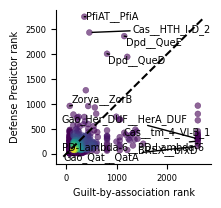

In [33]:
plt.subplots(figsize=(2, 2))
gpplot.point_densityplot(data=plot_top_pred_df, 
                         x='Guilt-by-association (p-value)', 
                         y='DefensePredictor', size=20)
gpplot.add_xy_line()
gpplot.label_points(data=plot_top_pred_df, 
                    x='Guilt-by-association (p-value)', y='DefensePredictor', 
                    label=plot_top_pred_df.sort_values('delta').head(5)['functional_group'], 
                    label_col='functional_group')
gpplot.label_points(data=plot_top_pred_df, 
                    x='Guilt-by-association (p-value)', y='DefensePredictor', 
                    label=plot_top_pred_df.sort_values('delta').tail(5)['functional_group'], 
                    label_col='functional_group')
plt.xlabel('Guilt-by-association rank')
plt.ylabel('Defense Predictor rank')
sns.despine()
plt.savefig('../figures/dp_gb_hth.svg', dpi=300, bbox_inches='tight')


## Investigate missed sequences

In [34]:
from IPython.display import display

In [35]:
pd.set_option('display.max_columns', 50)

In [36]:
cat_pr_df = pd.concat(og_pr_list)

In [37]:
cat_pr_df['method'].unique()

array(['BLAST nearest neighbor', 'DeepGO-SE', 'Defense BLAST search',
       'Defense HMM search', 'DefensePredictor',
       'ESM2 150M nearest neighbor', 'ESM2 650M nearest neighbor',
       'Foldseek/ProstT5 nearest neighbor',
       'Guilt-by-association (frequency)',
       'Guilt-by-association (p-value)',
       'MMseqs profile nearest neighbor', 'Random'], dtype=object)

In [38]:
for fold, fold_df in cat_pr_df[cat_pr_df['method'] == 'Guilt-by-association (p-value)'].groupby('test_fold'):
    print(fold)
    display(fold_df.head(50))

0


,precision,recall,prediction,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,method
690,0.956522,0.314286,1.000000,WP_013324670.1,f50c57797132ad90159de70d2f60257df7046e37250e32...,MPPSIYHITHLNNLASILRAGGLIANSRLRQQQINYTDIAHEQIQD...,None,None,None,None,True,GCF_000147335,DarTG__DarT,DarTG__DarT,DarTG__DarT,d1,0,WP_013324670.1|NC_014501.1|5151365|-,NC_014501.1,5151365,-,Guilt-by-association (p-value)
679,0.956522,0.314286,1.000000,WP_073185194.1,5b4207548353442084e425d2e9108e22022b07f8ca9604...,MSETQNEPRNADEPQQSDLDYKINLLFGGVVVRKDLVKAVKGNAIV...,None,None,None,None,True,GCF_900141915,BREX__brxL,BREX__brxL,BREX__brxL,d1,0,WP_073185194.1|NZ_FQZG01000003.1|13148|-,NZ_FQZG01000003.1,13148,-,Guilt-by-association (p-value)
668,0.956522,0.314286,1.000000,WP_199382287.1,59f8c8ce09652b77d8648d4a35a62b963c0b00f27e1a08...,MINQIDIASFGSFNDLNWKKSIRDGGNNVQDFKRLNILYGRNYSGK...,None,None,None,None,True,GCF_016458275,RloC__RloC,RloC__RloC,RloC__RloC,d1,0,WP_199382287.1|NZ_JAEMHM010000002.1|12582|+,NZ_JAEMHM010000002.1,12582,+,Guilt-by-association (p-value)
669,0.956522,0.314286,1.000000,WP_234977716.1,61a7c49924e6c4e9202912f32ddb164cff064a02af4037...,MLGENVEEKDEYYRFTWAGKNQARLEANKPTTATLRPNKADSKDWD...,None,None,None,None,True,GCF_900129405,RM_Type_III__Type_III_MTases,RM_Type_III__Type_III_MTases,RM_Type_III__Type_III_MTases,d1,0,WP_234977716.1|NZ_FQVQ01000018.1|44200|+,NZ_FQVQ01000018.1,44200,+,Guilt-by-association (p-value)
670,0.956522,0.314286,1.000000,WP_011791875.1,383e4b2375ad5797624286cc0c3c08e208bc12cfa7946b...,MRFIDNRHIRVPDGWNEKSQQALDDVCNYRCSVNDRSAVWRDLKDA...,None,None,None,None,True,GCF_000015485,Septu__PtuB,Septu__PtuB,Septu__PtuB,d1,0,WP_011791875.1|NC_008751.1|1056620|+,NC_008751.1,1056620,+,Guilt-by-association (p-value)
672,0.956522,0.314286,1.000000,WP_126609648.1,0eacfb38faf7944fe7cac0da1dd5d33578defa93cfe9f8...,MRSNYKKLGQFIRVVDTRNKENRKDNLLGVSTQKVFIDSVANTVGT...,None,None,None,None,True,GCF_019977755,RM__Type_I_S,RM__Type_I_S,RM__Type_I_S,d1,0,WP_126609648.1|NZ_AP025144.1|3686694|-,NZ_AP025144.1,3686694,-,Guilt-by-association (p-value)
673,0.956522,0.314286,1.000000,WP_097642351.1,a1e4c0b0e5de75ffe5b85b166a8509d5a58f398ef6f282...,MIRTLRLQNFKCFRDQEIELGNLTLLAGLNGMGKSSLIQALVLLRQ...,None,None,None,None,True,GCF_002532535,Menshen__NsnB,Menshen__NsnB,Menshen__NsnB,d1,0,WP_097642351.1|NZ_NQWI01000004.1|32301|+,NZ_NQWI01000004.1,32301,+,Guilt-by-association (p-value)
674,0.956522,0.314286,1.000000,WP_246091945.1,b3f30b862eed3fc0650e2e6fb88b647357cb2c078554ea...,MAMIYNFANLSHGDFENLVRDLVGRAIGVRFEAFAAGPDGGIDGRY...,TIR domain-containing protein,signal transduction,None,None,False,GCF_006335145,None,None,signal transduction,b13612,0,WP_246091945.1|NZ_VDMN01000009.1|32178|+,NZ_VDMN01000009.1,32178,+,Guilt-by-association (p-value)
675,0.956522,0.314286,1.000000,WP_254579396.1,e5086cf484bb86598cd54983195fad3406469d2f0cfc2d...,MAKKKPNRMQTKPATGSVSASLSTRLPALTASILGGSRGLDKPELA...,None,None,None,None,True,GCF_024267675,RM_Type_IV__Type_IV_REases,RM_Type_IV__Type_IV_REases,RM_Type_IV__Type_IV_REases,d1,0,WP_254579396.1|NZ_JALDYX010000004.1|136645|+,NZ_JALDYX010000004.1,136645,+,Guilt-by-association (p-value)
676,0.956522,0.314286,1.000000,WP_011939091.1,c17827cc9084f58eac674815602748d4cba3880fe64ff5...,MAEVPEKKKKAGRIKIPDKVVNQLWARAAGRCQFRGCNDILYSDDL...,None,None,None,None,True,GCF_000016745,CBASS__Sensing_SAVED,CBASS__Endonuc_small,CBASS__Endonuc_small,d1,0,WP_011939091.1|NC_009483.1|2570134|-,NC_009483.1,2570134,-,Guilt-by-association (p-value)


1


,precision,recall,prediction,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,method
661,0.642857,0.260870,1.0,WP_028116261.1,efcc5f44d49dccd09302aa46ea71c02579c2a538083a0b...,MTSQRQIFLHGPLGKRQTKEVIAAQLAALIMRPEPLWLVSPWISDF...,None,None,None,None,True,GCF_000422665,Dpd__DpdK,Dpd__DpdK,Dpd__DpdK,d146,1,WP_028116261.1|NZ_AUGM01000008.1|35058|-,NZ_AUGM01000008.1,35058,-,Guilt-by-association (p-value)
647,0.642857,0.260870,1.0,WP_008902073.1,59d84524511131e4d8c6b78b87e456cbbd294f2e51bb37...,MNLENIPEYLKENASWCLWKYETRNNRETKIPFNPTTNGYASVNDP...,"phage/plasmid primase, P4 family",DNA replication,None,None,False,GCF_000146345,None,None,DNA replication,b104,1,WP_008902073.1|NZ_GL397071.1|1355211|-,NZ_GL397071.1,1355211,-,Guilt-by-association (p-value)
634,0.642857,0.260870,1.0,WP_256385013.1,7bda85ae40f51d05206e14da9a1b0bf66118f8a24cedff...,MFLISPDKATVNESLESFLIRLCKANGFESYQIMALVIRDWLQDND...,None,None,None,None,True,GCF_024494545,Cas__TniQ_I-F_1,Cas__TniQ_I-F_1,Cas__TniQ_I-F_1,d165,1,WP_256385013.1|NZ_CP101696.1|186893|-,NZ_CP101696.1,186893,-,Guilt-by-association (p-value)
635,0.642857,0.260870,1.0,WP_148701153.1,0dcda0e1f46cba933ed6faba76fe4777ed64909d86a4d0...,MKDLITVTDVVENAFCPKFTYYSLVLGLRQYEEKRGTVMAGRTLHT...,None,None,None,None,True,GCF_000730285,Cas__cas4_I_II_III_IV_V_VI_1,Cas__cas4_I-A_2,Cas__cas4_I-A_2,d136,1,WP_148701153.1|NZ_CP007174.1|2118273|-,NZ_CP007174.1,2118273,-,Guilt-by-association (p-value)
636,0.642857,0.260870,1.0,WP_135459141.1,deb864f28217e2d461013a13f0782507d74e29ce3ade0e...,MSWFYKTVTFLPERCDNKVLAAKCLSILHGFNYKYDTRSIGVSFPD...,None,None,None,None,True,GCF_024347455,Cas__cas6f_I_II_III_IV_V_VI_1,Cas__cas6_I_II_III_IV_V_VI_21,Cas__cas6_I_II_III_IV_V_VI_21,d136,1,WP_135459141.1|NZ_AP025484.1|1345675|+,NZ_AP025484.1,1345675,+,Guilt-by-association (p-value)
637,0.642857,0.260870,1.0,WP_196991289.1,a4d65ad74d346a5145b6d208aa198da575ffc77903b451...,MAQTLTQIAQTLKANNKKVQLIYAFNGSGKTRLSRDFKELVAPKNA...,None,None,None,None,True,GCF_015831355,PrrC__PrrC,PrrC__PrrC,PrrC__PrrC,d215,1,WP_196991289.1|NZ_JADWYR010000002.1|291794|+,NZ_JADWYR010000002.1,291794,+,Guilt-by-association (p-value)
638,0.642857,0.260870,1.0,WP_133128015.1,547b95c0fdb3f176e67282fea14cd06649272d9132eef6...,MATCFIFARQIGHEHWLSLRLDDNNQMDAPLMVRSAAELQQLQINS...,type II secretion system protein GspL,protein secretion by the type II secretion system,None,None,False,GCF_900639915,None,None,protein secretion by the type II secretion system,b234,1,WP_133128015.1|NZ_CAAAID010000006.1|132508|+,NZ_CAAAID010000006.1,132508,+,Guilt-by-association (p-value)
639,0.642857,0.260870,1.0,WP_189015315.1,6cb36540ff145270ab48838b6634f3efa2b5518b8bf60a...,MKMTKDELNQSLNTFFQDEHELLAEIYFILKVGTETVLRFADIERD...,None,None,None,None,True,GCF_014640555,Kiwa__KwaB,Kiwa__KwaB_2,Kiwa__KwaB_2,d103,1,WP_189015315.1|NZ_BMHE01000027.1|59391|+,NZ_BMHE01000027.1,59391,+,Guilt-by-association (p-value)
640,0.642857,0.260870,1.0,WP_080806573.1,39c6916365ee4658e63ff00ac87115111c03f6c9a2d685...,MSKESILPGFEDQPETVSQGPVTCLGQAFENDEARRAHFTEELRKK...,None,None,None,None,True,GCF_900170035,BREX__pglXI,BREX__pglXI,BREX__pglXI,d63,1,WP_080806573.1|NZ_LT828554.1|68173|+,NZ_LT828554.1,68173,+,Guilt-by-association (p-value)
641,0.642857,0.260870,1.0,WP_044200466.1,bd0cbce478c3e2cc7c10b919556ddba54641099ae2a022...,MSYDPSRHHRRSIRLPGFDYRSPGAYYVTICTRERGLLFGDVIDHT...,transposase,transposition%2C DNA-mediated,None,None,False,GCF_000152145,None,None,transposition%2C DNA-mediated,b21,1,WP_044200466.1|NZ_GL501404.1|742208|+,NZ_GL501404.1,742208,+,Guilt-by-association (p-value)


2


,precision,recall,prediction,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,method
648,0.647059,0.318841,1.0,WP_015711894.1,0e39e0b2a243193e9a5340f4e10b9ca3d8620bfdc2285a...,MGPNIPKRLSAAILNSLQGGVVPRVGLEYVAVGRKREIETVLRDLE...,None,None,None,None,True,GCF_000214355,Shango__SngB,Shango__SngB,Shango__SngB,d183,2,WP_015711894.1|NC_015577.1|2459537|+,NC_015577.1,2459537,+,Guilt-by-association (p-value)
622,0.647059,0.318841,1.0,WP_072909398.1,e84d7d0d7af0b15c0ebcaf52451095a5b981c2063e92eb...,MKTFALVDCNNFYASCERLFRPDLKSQPVAVLSNNDGCIVARSQEV...,translesion error-prone DNA polymerase V subun...,DNA repair,None,None,False,GCF_900142125,None,None,DNA repair,b153,2,WP_072909398.1|NZ_FQZT01000011.1|103887|-,NZ_FQZT01000011.1,103887,-,Guilt-by-association (p-value)
628,0.647059,0.318841,1.0,WP_091434331.1,c1f6301adeba49bfc950cc163431429c897670441e40aa...,MMIQKKYKINRVQIRTLDMLRLQLIPFLLFILPLVTCPTWGQLGKK...,prolyl oligopeptidase family serine peptidase,proteolysis,None,None,False,GCF_900106645,None,None,proteolysis,b13,2,WP_091434331.1|NZ_FNMV01000014.1|79589|-,NZ_FNMV01000014.1,79589,-,Guilt-by-association (p-value)
627,0.647059,0.318841,1.0,WP_076995459.1,26fbb7f51f68d51d0ec8fde42b63da9d3a50b9aa18002b...,MNKSTLTFEEIKTQNLENLPDRITALYCRLSAEDANEGESNSISNQ...,recombinase family protein,DNA recombination,None,None,False,GCF_001984705,None,None,DNA recombination,b24,2,WP_076995459.1|NZ_MSPT01000001.1|206510|-,NZ_MSPT01000001.1,206510,-,Guilt-by-association (p-value)
626,0.647059,0.318841,1.0,WP_093309400.1,8bf717716d7090ac702e37ff0568327a5c601a048963b8...,MISYYLEWALSALNVSSITDFFVILLLTVCVISIVFKKKGIHVHFT...,None,None,None,None,True,GCF_900108915,Zorya__ZorA2,Zorya__ZorA,Zorya__ZorA,d169,2,WP_093309400.1|NZ_FNYH01000006.1|71673|+,NZ_FNYH01000006.1,71673,+,Guilt-by-association (p-value)
625,0.647059,0.318841,1.0,WP_072917327.1,1aa9d1650ad1708d3e378e4842dccd035915d24164d233...,MPIGWIDFSKDERNKVLNVIHLLDEPGAVDELGIGAIRDAFADYFF...,None,None,None,None,True,GCF_900141825,Azaca__ZacA,Azaca__ZacA,Azaca__ZacA,d59,2,WP_072917327.1|NZ_FQYQ01000013.1|64737|+,NZ_FQYQ01000013.1,64737,+,Guilt-by-association (p-value)
624,0.647059,0.318841,1.0,WP_214185933.1,18099c40934076bd70a7a1d6afaa4a5291afab9779c543...,MRYTQEQTREIVGLSVETLRHWRHVVTYLRPKTGKAARYTFSDLIS...,MerR family transcriptional regulator,regulation of transcription%2C DNA-templated,None,None,False,GCF_018501225,None,None,regulation of transcription%2C DNA-templated,b3764,2,WP_214185933.1|NZ_JAHCZI010000003.1|427379|+,NZ_JAHCZI010000003.1,427379,+,Guilt-by-association (p-value)
623,0.647059,0.318841,1.0,WP_243659989.1,a929a0a4e3ef0c02d17c5ddf365587358284bdbed0256e...,MNIYEKLDKIEPAITKSDFLENKGLGNEVGYFIFDYEPEYEIIVRE...,None,None,None,None,True,GCF_016458825,BREX__brxB_DUF1788,BREX__brxB_DUF1788,BREX__brxB_DUF1788,d21,2,WP_243659989.1|NZ_CP066744.1|1302537|+,NZ_CP066744.1,1302537,+,Guilt-by-association (p-value)
621,0.647059,0.318841,1.0,WP_086783467.1,713b7667d166f77e321da902396e7bc15d0281c428bd4a...,MTTDTTTTTFTLGPVGTEVDKRIRQLQQGALADRPAEVAALARLRR...,None,None,None,None,True,GCF_017876755,Cas__cse2gr11_I-E_8,Cas__csa5gr11_I-A_13,Cas__csa5gr11_I-A_13,d106,2,WP_086783467.1|NZ_JAGIOO010000001.1|2248470|-,NZ_JAGIOO010000001.1,2248470,-,Guilt-by-association (p-value)
631,0.647059,0.318841,1.0,WP_020531894.1,61170e9df901455d944679036303875a98706d2dd7988d...,MKINLSEHWPLLSVEDHIAHTVDGSMALCYRVQLPEIYSLGASDYD...,TraG family conjugative transposon ATPase,transposition,None,None,False,GCF_000379765,None,None,transposition,b536,2,WP_020531894.1|NZ_KB903470.1|6261|+,NZ_KB903470.1,6261,+,Guilt-by-association (p-value)


3


,precision,recall,prediction,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,method
656,0.842105,0.231884,1.000000,WP_048090053.1,197d9c2187559e803d0aef2e6151b34239747222980257...,MTENNMIPPYAPVIIKLLQGVIYNDDKEPWDNLVSYQVQIKEYFEL...,None,None,None,None,True,GCF_000685155,Wadjet__JetB_I,Wadjet__JetB_II,Wadjet__JetB_II,d39,3,WP_048090053.1|NZ_JMIY01000003.1|53841|+,NZ_JMIY01000003.1,53841,+,Guilt-by-association (p-value)
646,0.842105,0.231884,1.000000,WP_106683689.1,6d1847a434e03f36593c7e07d65351bb8ddae563ee0d28...,MTTWFVSRHPGALQWMRQHGPAFDQHVPHLDPAQVHPGDRVLGTLP...,None,None,None,None,True,GCF_003008575,Cas__csx16_III_1,Cas__csx16_III-D_1,Cas__csx16_III-D_1,d135,3,WP_106683689.1|NZ_CP027667.1|1725441|+,NZ_CP027667.1,1725441,+,Guilt-by-association (p-value)
639,0.842105,0.231884,1.000000,WP_072577263.1,1d6be1d72796b02ccd7b2181a9ef49705f617d43ebf5c8...,MAEKKSSEKRGPGMLSPITFLLKLSFGIISFLIFTTIMSILLDWFG...,TIGR03747 family integrating conjugative eleme...,biological_process,None,None,False,GCF_900460265,None,None,biological_process,b475,3,WP_072577263.1|NZ_UHIC01000001.1|1823546|+,NZ_UHIC01000001.1,1823546,+,Guilt-by-association (p-value)
640,0.842105,0.231884,1.000000,WP_012160773.1,b269429a59fb67737915fc61ad1b4e0a059c3a022f4f63...,MSRKKKAPNRVDELLDELIGENPQPEDILGESGLLKRLSKRLVERA...,IS256-like element ISAcma7 family transposase,None,COG3328,None,False,GCF_000018105,None,None,COG3328,b76,3,WP_012160773.1|NC_009925.1|3307829|+,NC_009925.1,3307829,+,Guilt-by-association (p-value)
641,0.842105,0.231884,1.000000,WP_008615200.1,8556105a96b3729efca345a73dc4ed88946474bb00d03e...,MDIEKFKNTIQDCNLNFLVGSGLSVPYFSTLGNIEVLLTELERNKT...,None,None,None,None,True,GCF_000260115,PD-T7-2__PD-T7-2_A,PD-T7-2__PD-T7-2_A,PD-T7-2__PD-T7-2_A,d170,3,WP_008615200.1|NZ_JH651379.1|3649008|-,NZ_JH651379.1,3649008,-,Guilt-by-association (p-value)
642,0.842105,0.231884,1.000000,WP_226443293.1,1c830313ab0486cc1ab82783bc525e2749a0e7e1ab29a0...,MNLDFPTLDALRSHHPAWRLLRSDHAPLIASFLHRAFIAPNVRVLP...,None,None,None,None,True,GCF_020510525,Wadjet__JetA_I,Wadjet__JetA_I,Wadjet__JetA_I,d39,3,WP_226443293.1|NZ_CP075188.1|1700011|-,NZ_CP075188.1,1700011,-,Guilt-by-association (p-value)
643,0.842105,0.231884,1.000000,WP_092913899.1,e7386355285715c2c1143dd8e256c3f17efe5a7939007b...,MRFLRNHQTPQEENHFWISISDLMTSLLFIFILILAYMILEYQDKQ...,None,None,None,None,True,GCF_900115615,Zorya__ZorB,Zorya__ZorB,Zorya__ZorB,d180,3,WP_092913899.1|NZ_FOXB01000047.1|9769|-,NZ_FOXB01000047.1,9769,-,Guilt-by-association (p-value)
644,0.842105,0.231884,1.000000,WP_203778149.1,2b5759bc74fbeef4925c078c6451c8de7c6e7193692a43...,MNGPTASGGNQRGARPRQPRRRSDDSGDGGQTSRPRQRQLDPLPGA...,None,None,None,None,True,GCF_016862115,Mokosh_TypeI__MkoA,Mokosh_TypeI__MkoA,Mokosh_TypeI__MkoA,d46,3,WP_203778149.1|NZ_BOMI01000212.1|6601|-,NZ_BOMI01000212.1,6601,-,Guilt-by-association (p-value)
645,0.842105,0.231884,1.000000,WP_144927821.1,26c4eb67a112e70f80fbe415b74ba69ebd38ab65b967d1...,MIDDDHLFDDPDPQFEESIRIDRDLEMEDAAERRDAQYRRYLDDYH...,None,None,None,None,True,GCF_007671685,BREX__brxC,BREX__brxC,BREX__brxC,d177,3,WP_144927821.1|NZ_VCNL01000010.1|8993|+,NZ_VCNL01000010.1,8993,+,Guilt-by-association (p-value)
647,0.842105,0.231884,1.000000,WP_033099863.1,65497b39e17e3284982cab8a106aa5f24befbc49e7ca0c...,MGKEQDVLRYYFRCFRDDGLSSKLGEGVNLSYQEMERGIVSEEFLR...,None,None,None,None,True,GCF_000763315,Mokosh_TypeII__MkoC,Mokosh_TypeII__MkoC,Mokosh_TypeII__MkoC,d46,3,WP_033099863.1|NZ_JPST01000008.1|101783|+,NZ_JPST01000008.1,101783,+,Guilt-by-association (p-value)


4


,precision,recall,prediction,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,method
673,0.760000,0.275362,1.0,WP_011673124.1,dbcc624d296b0bd6d1dbb2ca8c99f556038d22dea31c7c...,MNLTEQAFEKVTEKILSLAGKSENFPVYRIPIDLLKYNIKNGRIAT...,None,None,None,None,True,GCF_000014505,AbiR__AbiRb,AbiR__AbiRb,AbiR__AbiRb,d221,4,WP_011673124.1|NC_008525.1|591152|+,NC_008525.1,591152,+,Guilt-by-association (p-value)
661,0.760000,0.275362,1.0,WP_008863165.1,9685c23f2850c973d54c178dbab6c5be551772e8a8e677...,MEYKFNENTRVQVPAALHLCRLGYTYLDNITEYDSKTNILTDVFLS...,None,None,None,None,True,GCF_000296465,RM__Type_I_REases,RM__Type_I_REases,RM__Type_I_REases,d128,4,WP_008863165.1|NZ_JH815206.1|423044|+,NZ_JH815206.1,423044,+,Guilt-by-association (p-value)
649,0.760000,0.275362,1.0,WP_006023095.1,226da8b06afad3ba3fa8cabff7cab33ecda1547faae85f...,MTAYALIGHMGPADQAPDLTGRWQAQFRVDLLSGNRTLGYGIGGVI...,None,None,None,None,True,GCF_000314675,Gao_Qat__QatC,Gao_Qat__QatC,Gao_Qat__QatC,d24,4,WP_006023095.1|NZ_KB375284.1|505409|+,NZ_KB375284.1,505409,+,Guilt-by-association (p-value)
650,0.760000,0.275362,1.0,WP_068465094.1,ef41a2b8151bba565b573e4c85c6bc9597fbe3589b50a3...,MSREIYSEVRNIILEELKKDLVGPEYSSIDVLTEPPTQAYITGILY...,None,None,None,None,True,GCF_001687625,DISARM__drmA,DISARM__drmA,DISARM__drmA,d186,4,WP_068465094.1|NZ_CP016538.2|2967323|-,NZ_CP016538.2,2967323,-,Guilt-by-association (p-value)
651,0.760000,0.275362,1.0,WP_268811529.1,09c28cb6cbfd50297f83a20a50c2a991f3868f0f422674...,MGEDSKVKPARATASYKRAFWDAMRLNTSPMEVRNALSEGVDSEGG...,phage major capsid protein,virion assembly,None,None,False,GCF_900604285,None,None,virion assembly,b68,4,WP_268811529.1|NZ_UWNY01000004.1|416|+,NZ_UWNY01000004.1,416,+,Guilt-by-association (p-value)
652,0.760000,0.275362,1.0,WP_227026829.1,c53acdc1031d1d09a2381c8e29b9ff3a81505a2de69d52...,MHELYDPSSGRLYEVDLLFLSRQGLFLVEIKSHPGVLTGDIVDWTI...,protein kinase,protein phosphorylation,None,None,False,GCF_014930455,None,None,protein phosphorylation,b122,4,WP_227026829.1|NZ_JAAIYO010000001.1|436209|-,NZ_JAAIYO010000001.1,436209,-,Guilt-by-association (p-value)
653,0.760000,0.275362,1.0,WP_084871611.1,c6a2cb9008c78fe0754c91ec32736c8b706509f90b23bb...,MEYIGSKWWKFDFHTHTPVSMDYGKSDHEIKASMTPRQWLMDYISQ...,None,None,None,None,True,GCF_002095535,Gao_Ppl__PplA,Gao_Ppl__PplA,Gao_Ppl__PplA,d133,4,WP_084871611.1|NZ_MLJI01000001.1|4022|-,NZ_MLJI01000001.1,4022,-,Guilt-by-association (p-value)
655,0.760000,0.275362,1.0,WP_224187774.1,45450685c0959fbf14f27eef2c6e7e16713ccb7b9d1482...,MVLFTIDTDQFKIIIDHVDMSHIIKDRTYKLKLKKFVEAIEEETIY...,None,None,None,None,True,GCF_020097095,AbiR__AbiRc,AbiR__AbiRc,AbiR__AbiRc,d50,4,WP_224187774.1|NZ_CP083602.1|393868|+,NZ_CP083602.1,393868,+,Guilt-by-association (p-value)
656,0.760000,0.275362,1.0,WP_066322776.1,07171d994f879885184b997c05ed715ef94aa4205b662b...,MIILKQGNLLEDDAEALVNTVNCVGVMGKGIALQFKQAYPEMFSEY...,None,None,None,None,True,GCF_001634285,DarTG__DarG,DarTG__DarG,DarTG__DarG,d160,4,WP_066322776.1|NZ_CP015438.1|526181|+,NZ_CP015438.1,526181,+,Guilt-by-association (p-value)
657,0.760000,0.275362,1.0,WP_066888628.1,00142257b91a04f85834f21922d455b24879cca9e72eab...,MTVLRVAVTMLSDWHVGTGAGRHGVVDRMVQRDRDGLPYVPAKTLV...,None,None,None,None,True,GCF_001543925,Cas__csm3gr7_III-D_3,Cas__csm3gr7_III-D_2,Cas__csm3gr7_III-D_2,d2,4,WP_066888628.1|NZ_LAXD01000001.1|3465469|-,NZ_LAXD01000001.1,3465469,-,Guilt-by-association (p-value)


In [39]:
wide_predictions = (cat_predictions.pivot(index='seq_id', columns='method', values='prediction')
                    .reset_index()
                    .merge(model_seq_info, how='inner', on='seq_id'))

In [40]:
neighbors = pd.read_parquet('../data3/interim/model_neighbors_seq_ids.pq')

In [41]:
seq_id_names = pd.read_parquet('../data/interim/seq_id_names.pq')

In [42]:
neighbor_names = (neighbors.merge(seq_id_names, how='inner', 
                                  on='seq_id'))

In [43]:
wide_neighbor_names = (neighbor_names.pivot(index='center_seq_id', 
                                            columns='relative_position',
                                            values=['name', 'strand']))
wide_neighbor_names.columns = ['_'.join([str(y) for y in x]) for x in wide_neighbor_names.columns]
wide_neighbor_names = wide_neighbor_names.reset_index()

In [47]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 250)


In [49]:
(wide_predictions
 .sort_values('DefensePredictor', ascending=False)
 .query('~defensive')
 .query('DefensePredictor > 0.5')
 .groupby('test_fold')
 .head(200)
 .groupby('test_fold')
 .sample(50, random_state=7)
 .merge(wide_neighbor_names.rename(columns={'center_seq_id': 'seq_id'}), 
        how='inner', on='seq_id'))

,seq_id,BLAST nearest neighbor,DeepGO-SE,Defense BLAST search,Defense HMM search,DefensePredictor,ESM2 150M nearest neighbor,ESM2 650M nearest neighbor,Foldseek/ProstT5 nearest neighbor,Guilt-by-association (frequency),Guilt-by-association (p-value),MMseqs profile nearest neighbor,Random,product_accession,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,name_-2,name_-1,name_0,name_1,name_2,strand_-2,strand_-1,strand_0,strand_1,strand_2
0,f387ed85079bb4dc441b94fa6e364c42a20a3466a591a9...,33.9,0.001,33.9,0.0,0.967791,0.991664,-0.988699,-1230.0,0.000000,0.000000e+00,-47.0,0.0,WP_153419622.1,MIQKDLGFSIIPKAVNWKEGNVLHPSVLYYEFQRIDIINKQRFLIE...,type VI secretion system baseplate subunit TssK,protein secretion by the type VI secretion system,None,None,False,GCF_009208775,None,None,protein secretion by the type VI secretion system,b509,0,WP_153419622.1|NZ_WFLM01000002.1|677636|+,NZ_WFLM01000002.1,677636,+,hypothetical protein,hypothetical protein,type VI secretion system baseplate subunit TssK,DotU family type IV/VI secretion system protein,hypothetical protein,+,+,+,+,+
1,b3f30b862eed3fc0650e2e6fb88b647357cb2c078554ea...,110.0,0.034,110.0,0.0,0.999977,-0.992191,-0.990866,716.0,1.000000,1.000000e+00,430.0,0.0,WP_246091945.1,MAMIYNFANLSHGDFENLVRDLVGRAIGVRFEAFAAGPDGGIDGRY...,TIR domain-containing protein,signal transduction,None,None,False,GCF_006335145,None,None,signal transduction,b13612,0,WP_246091945.1|NZ_VDMN01000009.1|32178|+,NZ_VDMN01000009.1,32178,+,hypothetical protein,SIR2 family protein,TIR domain-containing protein,hypothetical protein,hypothetical protein,-,-,+,+,+
2,3d74661a19ccbc6fa991554ceaf9dd4e16f831e11032be...,-30.8,0.003,0.0,0.0,0.503041,0.987323,0.973730,-339.0,0.000000,0.000000e+00,-85.0,0.0,WP_061167213.1,MRIDKPLWHEGLILTQQHFQQQERWSEFALRQFTTAAMTHPWGTLH...,type VI secretion system baseplate subunit TssK,protein secretion by the type VI secretion system,None,None,False,GCF_001544875,None,None,protein secretion by the type VI secretion system,b509,0,WP_061167213.1|NZ_FCOA02000004.1|246233|+,NZ_FCOA02000004.1,246233,+,type VI secretion system baseplate subunit TssF,type VI secretion system baseplate subunit TssG,type VI secretion system baseplate subunit TssK,DotU family type IV/VI secretion system protein,type VI secretion system baseplate subunit TssE,+,+,+,+,+
3,ea2ae6d19a96301da95c5bce9006359424d1eb313b1a48...,-128.0,0.014,60.1,84.5,0.899892,-0.993474,-0.996360,-1071.0,0.000000,0.000000e+00,-160.0,0.0,WP_013459759.1,MSTEYLKTDYEKLAYFVNLLKSRASGKNVSEREYTELREELLSNKI...,protein kinase,protein phosphorylation,None,None,False,GCF_000183725,None,None,protein phosphorylation,b17068,0,WP_013459759.1|NC_014762.1|898158|+,NC_014762.1,898158,+,DNA mismatch repair protein,DEAD/DEAH box helicase family protein,protein kinase,type I restriction-modification system subunit M,restriction endonuclease subunit S,+,+,+,+,+
4,4cc5c9446cfddfe6e2e7ba3ce8222a2e4c8a7b50f29410...,0.0,0.012,157.0,243.9,0.741832,0.982413,0.980582,1183.0,0.000000,0.000000e+00,0.0,0.0,WP_223839217.1,MSRSTGLTDFWDEVAEDLRNGGWRPLPARRVLIPKPGTKERRPLSI...,group II intron reverse transcriptase/maturase,Group II intron splicing,None,None,False,GCF_014697215,None,None,Group II intron splicing,b33,0,WP_223839217.1|NZ_CP031142.1|4083887|+,NZ_CP031142.1,4083887,+,3-methyl-2-oxobutanoate hydroxymethyltransferase,IS630 family transposase,group II intron reverse transcriptase/maturase,IS630 family transposase,tyrosine-type recombinase/integrase,+,+,+,-,+
5,fc0b46387cc4bf71a7ac7f896d2c87c8664c21fe2e0975...,-55.8,0.002,0.0,0.0,0.869629,0.988215,-0.986671,-719.0,0.000000,0.000000e+00,-141.0,0.0,WP_133581139.1,MAAGNFGDVVKHMVLLELVSLMVKDPQRKTSHFKYFETHGSEIEHA...,23S rRNA (adenine(2030)-N(6))-methyltransferas...,rRNA base methylation,None,None,False,GCF_004363045,None,None,rRNA base methylation,b18200,0,WP_133581139.1|NZ_SNYJ01000012.1|33476|+,NZ_SNYJ01000012.1,33476,

In [50]:
(wide_predictions
 .sort_values('DefensePredictor', ascending=True)
 .query('defensive')
 .query('DefensePredictor < 0.5')
 .groupby('test_fold')
 .head(200)
 .groupby('test_fold')
 .sample(50, random_state=7)
 .merge(wide_neighbor_names.rename(columns={'center_seq_id': 'seq_id'}), 
        how='inner', on='seq_id'))

,seq_id,BLAST nearest neighbor,DeepGO-SE,Defense BLAST search,Defense HMM search,DefensePredictor,ESM2 150M nearest neighbor,ESM2 650M nearest neighbor,Foldseek/ProstT5 nearest neighbor,Guilt-by-association (frequency),Guilt-by-association (p-value),MMseqs profile nearest neighbor,Random,product_accession,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group,cluster,test_fold,protein_context_id,genomic_accession,start,strand,name_-2,name_-1,name_0,name_1,name_2,strand_-2,strand_-1,strand_0,strand_1,strand_2
0,7213744a7d20fa03317d723713ecce6f16e56d3e0078b2...,0.0,0.002,26.2,0.0,2.205797e-06,-0.986064,-0.989257,-512.0,0.000000,0.000000,-42.0,0.0,WP_108854337.1,MPGPERYRIAMGGWIAAAWCLGVSPVAAQLYDDAALQADAARYEER...,None,None,None,None,True,GCF_900302475,Lit__Lit,Lit__Lit,Lit__Lit,d1,0,WP_108854337.1|NZ_OMOQ01000003.1|318721|-,NZ_OMOQ01000003.1,318721,-,hypothetical protein,hypothetical protein,hypothetical protein,SDR family NAD(P)-dependent oxidoreductase,2-isopropylmalate synthase,-,-,-,+,-
1,0c886f42d64f626053cd217357472b3a9b9f93e3d6cacc...,-40.4,0.002,31.2,0.0,4.970924e-06,-0.986329,-0.986165,-221.0,0.054348,0.229910,-106.0,0.0,WP_136850829.1,MDDKWTYDELKAAVLAYVEMRELEASGQPFTKKQYYRDLAGKFGRT...,None,None,None,None,True,GCF_005116715,RM_Type_IV__Type_IV_REases,RM_Type_IV__Type_IV_REases,RM_Type_IV__Type_IV_REases,d1,0,WP_136850829.1|NZ_SWCI01000001.1|442398|+,NZ_SWCI01000001.1,442398,+,co-chaperone GroES,chaperonin GroEL,HNH endonuclease signature motif containing pr...,hypothetical protein,hypothetical protein,+,+,+,+,+
2,35d567fd8ac60e21b2d278ead428bed2b6a407896090b4...,0.0,0.000,0.0,0.0,1.309398e-07,-0.980600,-0.986058,-374.0,0.000000,0.000000,0.0,0.0,WP_185686121.1,MATAAGLTPLLGPAATPPAPRPTGALRVTTIARRLLLANADGCAER...,None,None,None,None,True,GCF_014230345,Lit__Lit,Lit__Lit,Lit__Lit,d1,0,WP_185686121.1|NZ_JACLAV010000012.1|56933|+,NZ_JACLAV010000012.1,56933,+,UDP-glucose 4-epimerase GalE,DUF4136 domain-containing protein,M48 family metallopeptidase,DUF4136 domain-containing protein,carboxypeptidase family protein,-,+,+,+,+
3,b21066d00a5af38b0912796798d60afc75ec51ef063f0a...,-57.8,0.001,0.0,0.0,6.561932e-08,-0.977366,-0.979680,-365.0,0.000000,0.000000,-86.0,0.0,WP_250635836.1,MTKKVQILVIGHNDNGCTPTHEKIAYEIGCEVAKASCVLITGGLGG...,None,None,None,None,True,GCF_000241145,PsyrTA__PsyrA,PsyrTA__PsyrA,PsyrTA__PsyrA,d1,0,WP_250635836.1|NZ_AHJG01000318.1|595|+,NZ_AHJG01000318.1,595,+,hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein,3-hydroxyacyl-CoA dehydrogenase family protein,-,-,+,+,-
4,e7802d97892a5e6051b5b645504c201a596edf77794051...,-41.6,0.001,0.0,0.0,1.425937e-05,-0.980798,-0.983813,-246.0,0.000000,0.000000,-62.0,0.0,WP_277529075.1,MAVVNAFNQNRLKSARIFMGLTISELADASGVSKQAISQFENGKTK...,None,None,None,None,True,GCF_029525575,RosmerTA__RmrA_2600853143,RosmerTA__RmrA_2623274509,RosmerTA__RmrA_2623274509,d1,0,WP_277529075.1|NZ_JAPDIA010000001.1|695201|-,NZ_JAPDIA010000001.1,695201,-,hypothetical protein,hypothetical protein,helix-turn-helix transcriptional regulator,ImmA/IrrE family metallo-endopeptidase,hypothetical protein,-,-,-,-,-
5,963b2c0ec655215d896583fd81198bcab85435e93b4c30...,-115.0,0.003,28.1,0.0,4.050201e-09,-0.978761,-0.986339,-1781.0,0.000000,0.000000,-164.0,0.0,WP_251318168.1,MKLSDLRKHKKFLIAVVCVLAAIAMGAVFLQPKAEPEDDVIWREYP...,None,None,None,None,True,GCF_943192995,Lamassu-Fam__LmuB_SMC_Cap4_nuclease_II,Lamassu-Fam__LmuB_SMC_Sir2,Lamassu-Fam__LmuB_SMC_Sir2,d1,0,WP_251318168.1|NZ_CALPCP010000016.1|9631|+,NZ_CALPCP010000016.1,9631,+,response regulator transcription factor,HAMP domain-containing histidine kinase,efflux RND transporter periplasmic adaptor sub...,ABC transporter permease,hypothetical protein,+,+,+,+,+
6,c4cb80bf689e2ff0f88460f719d37c31d00316a669ffd5...,0.0,0.001,0.0,0.0,5.064877e-06,-0.987746,0.990054,-1094.0,0.500000,0.866533,0.0,0.0,WP_207566800.1,MKKETAAIFALTRTKLTNEKINKIILFAFGNGISISQILTLKNHEL...,None,None,None,None,True,GCF_017358165,PsyrT